In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/emotions_dataset.csv')

In [3]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


In [4]:
df.describe()

,text,label
count,416809,416809
unique,393822,6
top,i feel more adventurous willing to take risks,joy
freq,16,141067


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB


In [6]:
df.isna().sum()

text     0
label    0
dtype: int64

In [7]:
df.shape

(416809, 2)

In [8]:
df['label'].value_counts()

label
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64

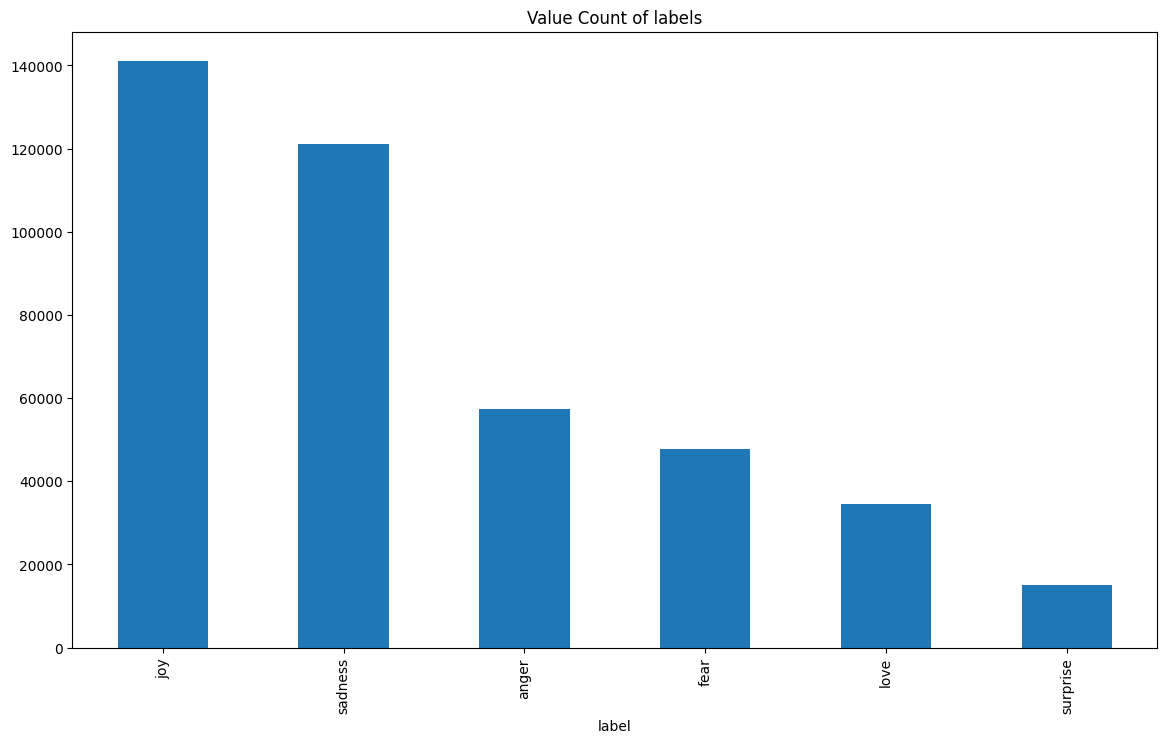

In [9]:
plt.figure(figsize=(14, 8))
df['label'].value_counts().plot(kind='bar')
plt.title('Value Count of labels')
plt.show()

In [10]:
from wordcloud import WordCloud

In [11]:
all_text = ' '.join(df['text'])

In [12]:
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=50
).generate(all_text)

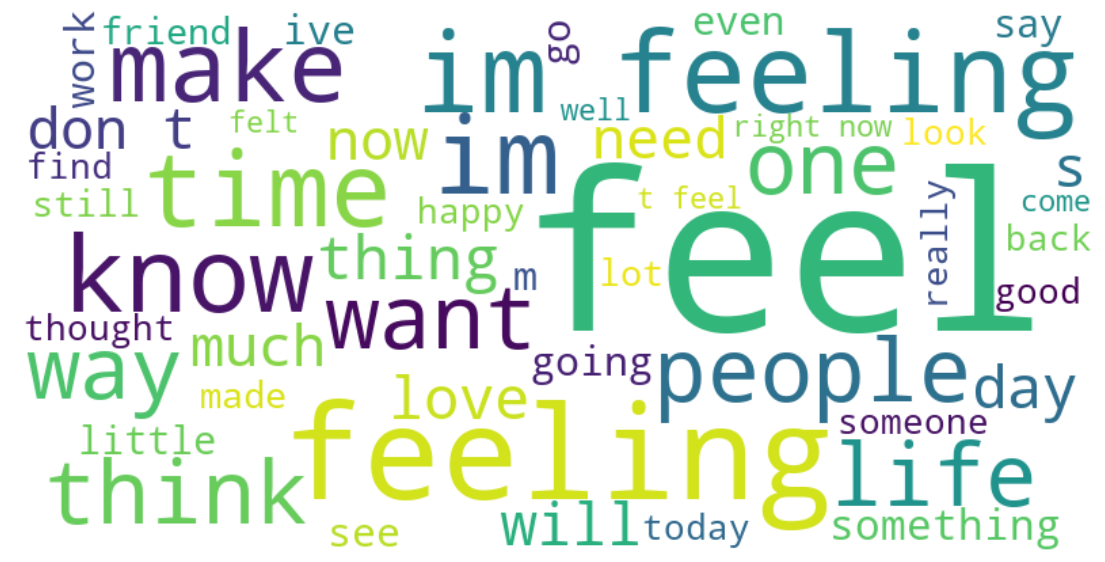

In [13]:
# Plot the word cloud
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# preprocessing text

In [14]:
import re
import nltk
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [16]:
def clean_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [17]:
df['clean_text'] = df['text'].apply(clean_text)

In [18]:
df.head()

,text,label,clean_text
0,i just feel really helpless and heavy hearted,fear,feel really helpless heavy hearted
1,ive enjoyed being able to slouch about relax a...,sadness,ive enjoyed able slouch relax unwind frankly n...
2,i gave up my internship with the dmrg and am f...,fear,gave internship dmrg feeling distraught
3,i dont know i feel so lost,sadness,dont know feel lost
4,i am a kindergarten teacher and i am thoroughl...,fear,kindergarten teacher thoroughly weary job take...


In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
X = df['clean_text']
y = df['label']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
label = LabelEncoder()

In [23]:
label.fit(y_train)

y_train = label.transform(y_train)
y_test = label.transform(y_test)

In [24]:
from tensorflow.keras.utils import to_categorical

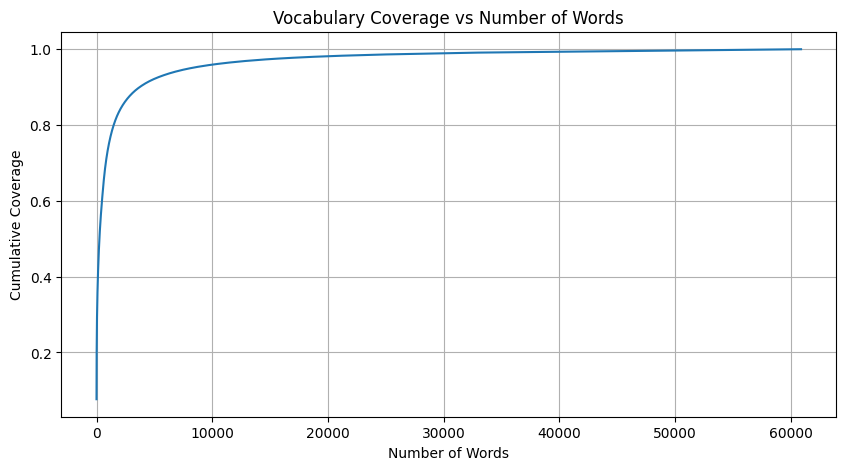

In [25]:
full_tokenizer = Tokenizer(oov_token='<OOV>')
full_tokenizer.fit_on_texts(X_train)

word_counts = sorted(full_tokenizer.word_counts.values(), reverse=True)
cumulative_coverage = np.cumsum(word_counts) / sum(word_counts)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_coverage)
plt.xlabel("Number of Words")
plt.ylabel("Cumulative Coverage")
plt.title("Vocabulary Coverage vs Number of Words")
plt.grid()
plt.show()

In [26]:
vocab_size = next(i for i, c in enumerate(cumulative_coverage) if c >= 0.95)
print(f"Vocabulary size for 95% coverage: {vocab_size}")

Vocabulary size for 95% coverage: 8126


In [27]:
max_vocab_size = 8126

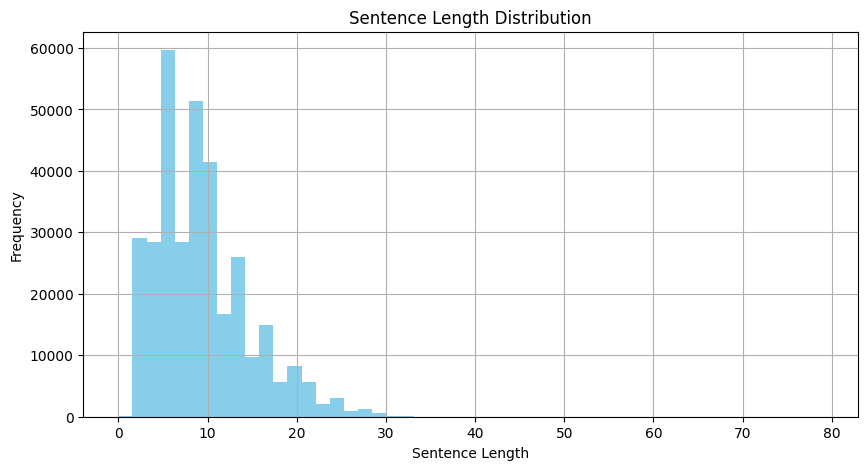

In [ ]:
sentence_lengths = [len(sentence.split()) for sentence in X_train]

plt.figure(figsize=(10, 5))
plt.hist(sentence_lengths, bins=50, color='skyblue')
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.title("Sentence Length Distribution")
plt.grid()
plt.show()

In [31]:
max_length = np.percentile(sentence_lengths, 100)
print(f"Max sequence length for 100% coverage: {int(max_length)}")

Max sequence length for 100% coverage: 79


In [32]:
max_sequence_length = 80

In [33]:
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

In [34]:
import pickle

with open('../model/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [35]:
with open('../model/label.pkl', 'wb') as file:
    pickle.dump(label, file)

In [36]:
from tensorflow.keras.utils import to_categorical

In [37]:
y_train_categorical = to_categorical(y_train, num_classes=6)
y_test_categorical = to_categorical(y_test, num_classes=6)

# Model architecture

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [41]:
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    
    Bidirectional(LSTM(128, return_sequences=False)),
    
    # Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Dropout(0.5),
    
    Dense(6, activation='softmax')
])

In [42]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the model
history = model.fit(
    X_train_padded, y_train_categorical,
    validation_data=(X_test_padded, y_test_categorical),
    epochs=2,
    batch_size=32,
    verbose=1
)

Epoch 1/2
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1234s 118ms/step - accuracy: 0.8673 - loss: 0.3178 - val_accuracy: 0.9394 - val_loss: 0.0956
Epoch 2/2
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 1457s 140ms/step - accuracy: 0.9402 - loss: 0.0934 - val_accuracy: 0.9397 - val_loss: 0.0926


In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 128)        │     1,040,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,966,068 (15.13 MB)

 Trainable params: 1,322,022 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,644,046 (10.09 MB)

In [46]:
model.save('../model/model-V2.h5')

In [47]:
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Loss: {loss:.2f}")

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 101s 39ms/step - accuracy: 0.9403 - loss: 0.0929
Test Accuracy: 0.94
Test Loss: 0.09


In [48]:
from sklearn.metrics import confusion_matrix

In [56]:
y_pred = model.predict(X_test_padded)
# confusion_matrix(y_test_categorical, y_pred)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 97s 37ms/step


In [71]:
predicted_class = [np.argmax(pred) for pred in y_pred]

In [72]:
confusion_matrix(y_test, predicted_class)

array([[11032,   350,    40,     0,    19,     0],
       [  191,  8564,    28,     0,    16,   795],
       [   56,    11, 27198,   770,    15,   114],
       [    0,     0,  1337,  5586,     4,     2],
       [  602,   437,    34,     2, 23101,    25],
       [    0,     4,   169,     0,     2,  2858]])

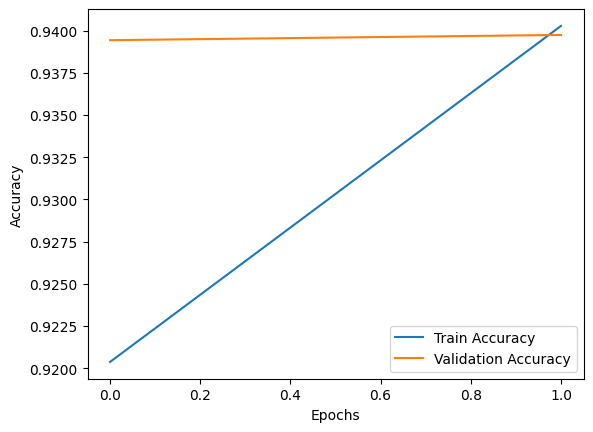

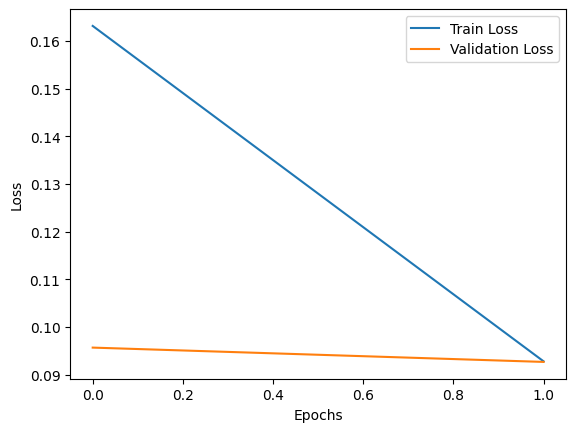

In [73]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Inference

In [74]:
def predict_emotion(text):
    text_cleaned = clean_text(text)
    
    text_seq = tokenizer.texts_to_sequences([text_cleaned])
    
    text_padded = pad_sequences(text_seq, maxlen=max_sequence_length, padding='post')
    
    prediction = model.predict(text_padded)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    emotion_label = label.inverse_transform([predicted_class])[0]
    
    return emotion_label


In [81]:
input_text = "i dont know i feel so lost"

predicted_emotion = predict_emotion(input_text)
print(f"The emotion of the text is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
The emotion of the text is: sadness
